In [6]:

import os
from detanet_model import *

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

dataset = []

# Load the dataset
dataset = torch.load(os.path.join(data_dir, 'KITQM9.pt'))
print(f"Number of graphs in the dataset: {len(dataset)}")

for data in dataset:
    data.x = data.spectra.repeat(len(data.z), 1)

ex1 = dataset[0]
print("dataset[0] :", ex1, )

Number of graphs in the dataset: 5159
dataset[0] : Data(pos=[7, 3], idx='KITQM9_34', dataset_name='KITQM9', smiles='OCC#N', z=[7], freqs=[62], spectra=[62], real_ee=[62, 3, 3], imag_ee=[62, 3, 3], real_em=[62, 3, 3], imag_em=[62, 3, 3], real_mm=[62, 3, 3], imag_mm=[62, 3, 3], osc_pos=[15], osc_strength=[15], x=[7, 62])


In [7]:

# -------------------------------
# Shuffle & Train/Val Split
# -------------------------------
import random
random.seed(42)
random.shuffle(dataset)
train_frac = 0.9
split_index = int(train_frac * len(dataset))

train_datasets = dataset[:split_index]
val_datasets   = dataset[split_index:]


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch


# ---------- helpers -----------------------------------------------------------
def minmax_scale(arr):
    """Scale to [0, 1]; if all values equal → zeros."""
    arr = np.asarray(arr, dtype=float)
    amin, amax = arr.min(), arr.max()
    return np.zeros_like(arr) if abs(amax - amin) < 1e-15 else (arr - amin) / (amax - amin)


def _split_real_imag(pred_tensor):
    real = pred_tensor[:62,:,:]          # [:, :, 0]  [:, :, 1]  [:, :, 2]
    imag = pred_tensor[62:,:,:]
    return real, imag


# ---------- main --------------------------------------------------------------
def plot_polarizability_matrix_3x3(data_entry, gt_real, gt_imag, model, out_dir=".", symmetric=True):
    """
    Makes two figures per molecule:
      • 3×3 real-part GT vs prediction
      • 3×3 imag-part GT vs prediction
    Output files:
      polar_real_<mol-idx>_<dataset>.png
      polar_imag_<mol-idx>_<dataset>.png
    """

    # Ensure output folder exists
    os.makedirs(out_dir, exist_ok=True)

    # --------------------- fetch GT -------------------------------------------
    freqs   = np.asarray(data_entry.freqs)  # [N]

    # --------------------- predictions ---------------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = model.to(device).eval()

    with torch.no_grad():
        pred = model(
            z=data_entry.z.to(device),
            pos=data_entry.pos.to(device),
            x_features=data_entry.x.to(device)
        ).cpu().numpy()                    # [N,3,6]

    pred_real, pred_imag = _split_real_imag(pred)  # both [N,3,3]
    print(f"GT shape: {gt_real.shape}, Pred shape: {pred_real.shape}")

    # -------------------------------------------------------------------------
    def _plot_one_part(gt, pred, part_name, fprefix):
        """Draw a single 3×3 grid with redundant upper-triangular
        panels removed when `symmetric=True`."""
        fig, axes = plt.subplots(3, 3, figsize=(11, 9), sharex=True, sharey=False)
        fig.suptitle(f"{part_name.capitalize()} Polarizability – Mol {data_entry.idx}",
                    fontsize=14)

        # ▲ keep only the lower-triangle (r ≥ c) if symmetric
        pairs = [(r, c) for r in range(3) for c in range(3)
                if not (symmetric and r < c)]

        # global min–max across the panels that will be shown
        flat = np.hstack([gt[:, i, j].ravel() for (i, j) in pairs] +
                        [pred[:, i, j].ravel() for (i, j) in pairs])
        ymin, ymax = flat.min(), flat.max()

        for r in range(3):
            for c in range(3):
                ax = axes[r, c]

                if symmetric and r < c:                      # ▲ remove panel
                    fig.delaxes(ax)
                    continue

                gt_vals   = gt[:, r, c]
                pred_vals = pred[:, r, c]

                ax.plot(freqs, gt_vals,   'o', ms=3, color='royalblue', alpha=0.7,
                        label="Ground Truth" if (r, c) == (0, 0) else None)
                ax.plot(freqs, pred_vals, 'o', ms=3, color='tab:orange', alpha=0.7,
                        label="Prediction"  if (r, c) == (0, 0) else None)

                ax.set_ylim(ymin, ymax)
                ax.set_xlim(freqs.min(), freqs.max())
                ax.set_title(f"({r},{c})", fontsize=10)
                if r == 2:
                    ax.set_xlabel("Frequency (eV)")
                if c == 0:
                    ax.set_ylabel("Intensity")

        # consolidated legend
        handles, labels = axes[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', frameon=False)

        plt.tight_layout(rect=[0, 0, 0.97, 0.95])
        fname = os.path.join(out_dir,
                            f"{fprefix}_{data_entry.idx}_{data_entry.dataset_name}.png")
        #plt.savefig(fname, dpi=300)
        plt.show()
        plt.close(fig)

    # ------------------------- draw & save ------------------------------------
    _plot_one_part(gt_real, pred_real, "real", "polar_real")
    _plot_one_part(gt_imag, pred_imag, "imag", "polar_imag")


In [9]:
# -------------------------------
# Create Model
# -------------------------------
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = DetaNet(num_features=256,
                    act='swish',
                    maxl=3,
                    num_block=3, #3
                    radial_type='trainable_bessel',
                    num_radial=32,
                    attention_head=16,
                    rc=3,
                    dropout=0.0,
                    use_cutoff=False,
                    max_atomic_number=34,
                    atom_ref=None,
                    scale=1.0,
                    scalar_outsize=(4*62), # 2,#4, 
                    irreps_out= '124x2e', #'2e',# '2e+2e',
                    summation=True,
                    norm=False,
                    out_type='cal_multi_tensor',
                    grad_type=None,
                    x_features=62,
                    device=device)


params=current_dir + '/trained_param/pretty_sweep_polar_Falsenormalize_70epochs_32bs_0_0006855550241449846lr.pth'
state_dict = torch.load(params)
model.to(device)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

GT shape: torch.Size([62, 3, 3]), Pred shape: (62, 3, 3)


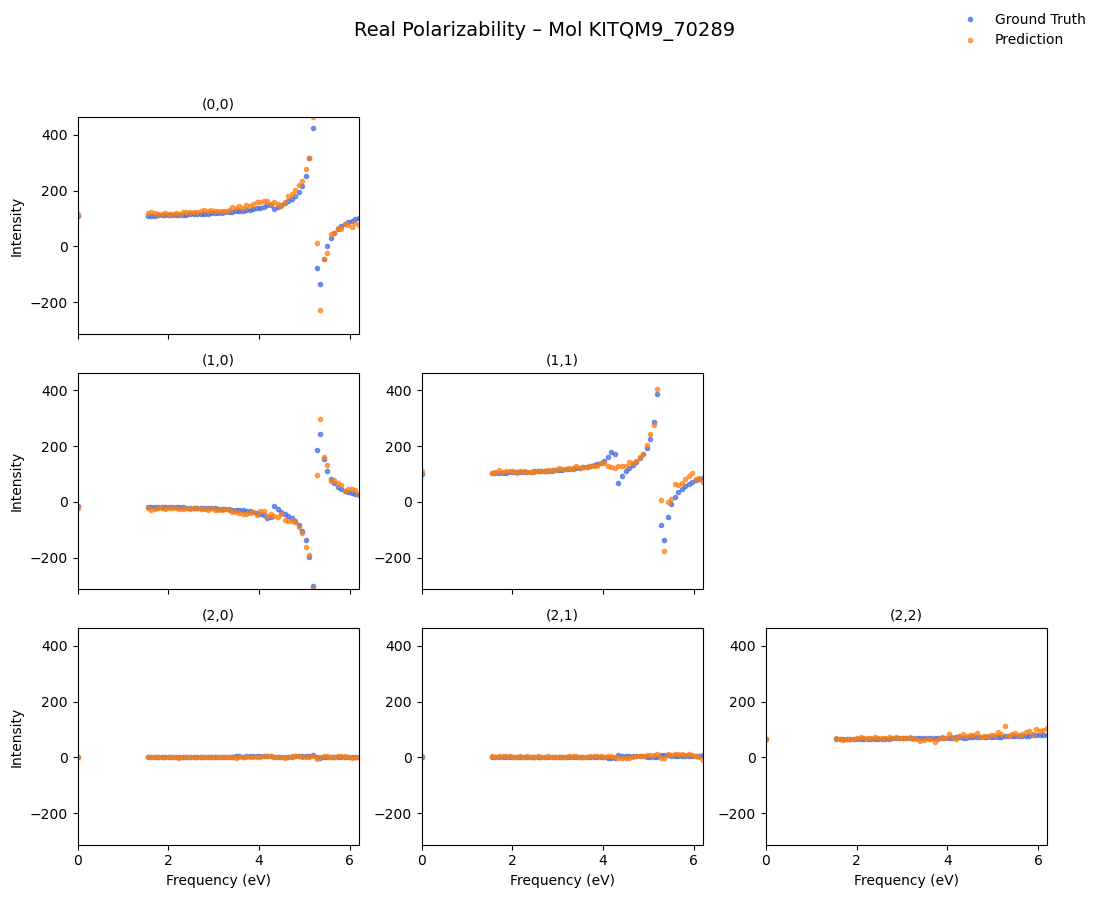

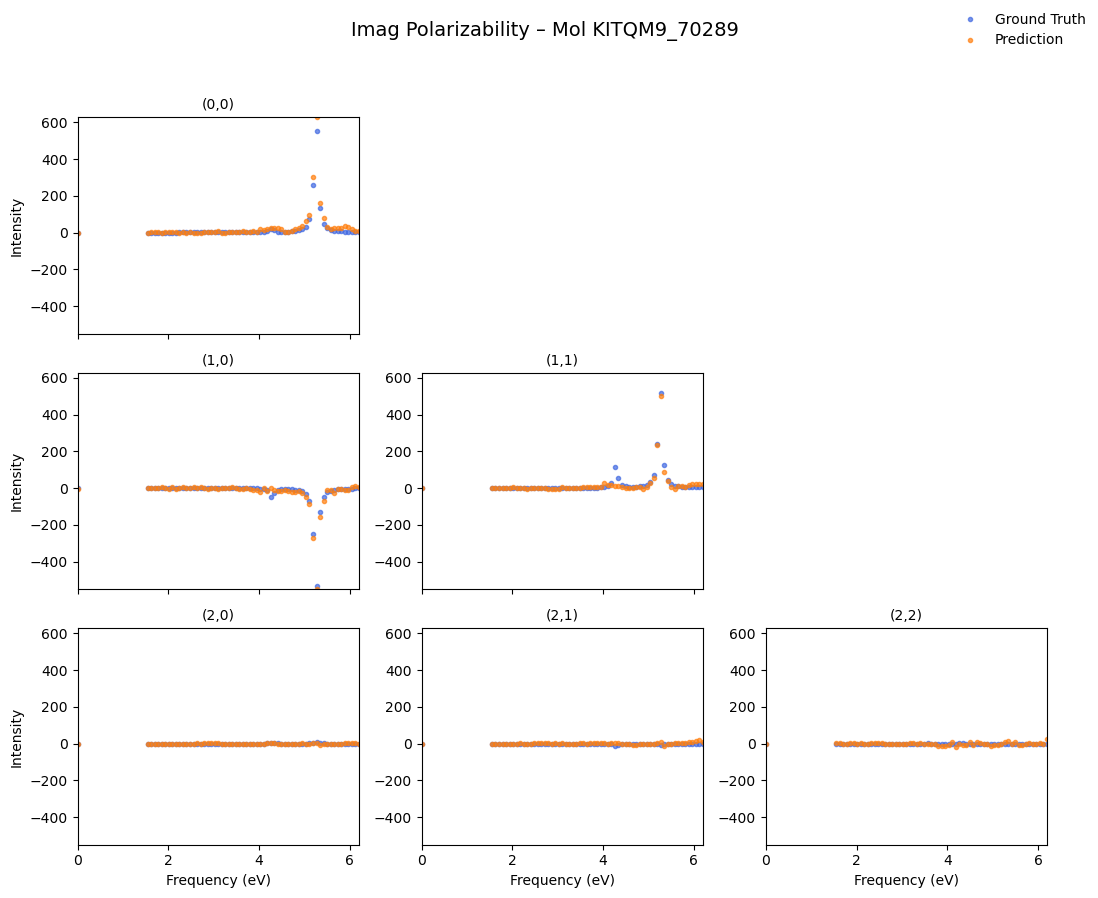

In [10]:
for i in range(1):
    data_entry = val_datasets[i]  # Assuming you want to plot the first entry

    plot_polarizability_matrix_3x3(data_entry, data_entry.real_ee, data_entry.imag_ee, model)